In [1]:
from azure.quantum import Workspace
workspace = Workspace (
   resource_id = "/subscriptions/646a7369-d450-42a2-b218-fda1b458300b/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QuantumGO2",
   location = "westcentralus"
)


%pip install openqaoa

%pip install pandas
%pip install requests
%pip install geojson
%pip install geopandas
%pip install qiskit
%pip install fiona
%pip install pyogrio
%pip install pyproj
%pip install rtree 
%pip install shapely
%pip install numpy
%pip install geodatasets
%pip install geoplot
%pip install matplotlib
%pip install qiskit[visualization]
%pip install folium
%pip install libpysal
%pip install dwave-ocean-sdk
%pip install networkx




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [2]:


from qiskit import QuantumCircuit, execute, transpile
from qiskit.providers.basicaer import UnitarySimulatorPy
from qiskit.tools.monitor import job_monitor

import pandas
import pyogrio 
import requests

import folium
import fiona 

import openqaoa

import networkx as nx
import pyproj
import rtree
import shapely
import geojson
import matplotlib as mpl
import matplotlib.pyplot as pyp
import geopandas as gpd
import geodatasets
import dimod

import libpysal
from libpysal import weights

import scipy
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix



import numpy as np
import numpy.random as random


%matplotlib inline

import sympy as sp

import matplotlib.pyplot as plt

from math import acos

# Printing configuration
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from IPython.display import display, Markdown

from openqaoa.problems import MaximumCut, NumberPartition, MinimumVertexCover, QUBO
from openqaoa.utilities import plot_graph, ground_state_hamiltonian
from openqaoa.qaoa_components import Hamiltonian

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

Helper Methods

In [3]:
def tupleToStr(tuple):

    returnStr = "("
    for element in tuple:
        returnStr += element + ", "
    
    return returnStr + ")"

Importing GeoJSON Files 

In [4]:
url_coal_mines = "https://drive.google.com/uc?export=download&id=1IRDLahuRcxAqst2vjas7FEGvBPJBtSjH"
url_us_cities = "https://drive.google.com/uc?export=download&id=1eQZ0z2kuSvYf8UtHwY3NYcQne9wNfANG"

coal_file = gpd.read_file(url_coal_mines)
cities_file = gpd.read_file(url_us_cities)

coal_file.crs
cities_file.crs

cities_file.head(5)


,name,country.etc,pop,capital,geometry
0,Abilene TX,TX,113888,0,POINT (-99.74000 32.45000)
1,Akron OH,OH,206634,0,POINT (-81.52000 41.08000)
2,Alameda CA,CA,70069,0,POINT (-122.26000 37.77000)
3,Albany GA,GA,75510,0,POINT (-84.18000 31.58000)
4,Albany NY,NY,93576,2,POINT (-73.80000 42.67000)


In [5]:


mpl.rcParams['figure.figsize'] = (15, 15)
#coal_points = coal_file.plot(color='red')




In [6]:
def m_dist(coord1, coord2):


    return abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1])

Setting up the Node Class

In [7]:
class QAOANode:

    neighbors = []

    def __init__(self, point):
        self.point = point
        self.coordinates = (point["geometry"].x, point["geometry"].y)

    def __str__(self):
        return f"{self.coordinates}"

In [8]:
coal_nodes = []
coal_coords = []

city_nodes = []
city_coords = []

#the row is what gives the point data itself -- state, coordinates, etc

for idx, row in coal_file.iterrows():
    node = QAOANode(row)

    coal_nodes.append(node)
    coal_coords.append(node.coordinates)
    

for idx, row in cities_file.iterrows():
    node = QAOANode(row)

    city_nodes.append(node)
    city_coords.append(node.coordinates)


coal_node_coord = dict(zip(coal_nodes, coal_coords))
city_node_coord = dict(zip(city_nodes, city_coords))

coal_city_node_coords = {**coal_node_coord, **city_node_coord}



Setting up Distance Matrix  

In [9]:
import numpy as np
from sklearn.metrics import pairwise_distances

# Two sets of binary data points
# Compute binary distance matrix between the two sets
dist_band = pairwise_distances(np.array(coal_coords), np.array(city_coords), metric='manhattan')

#get the max dimension we have
rows, cols = dist_band.shape
max_dim = max(rows, cols)

#create a new matrix filled with zeroes using the max dimension
#then copy over the existing values in the dist_band to this new square matrix
square_mat = np.zeros((max_dim, max_dim))
square_mat[:rows, :cols] = dist_band

#100 being a certain user set threshold
print("Set Distance Threshold for Edges")
threshold = float(input())
square_mat[square_mat > threshold] = 0



Set Distance Threshold for Edges


Drawing NetworkX Graph

576


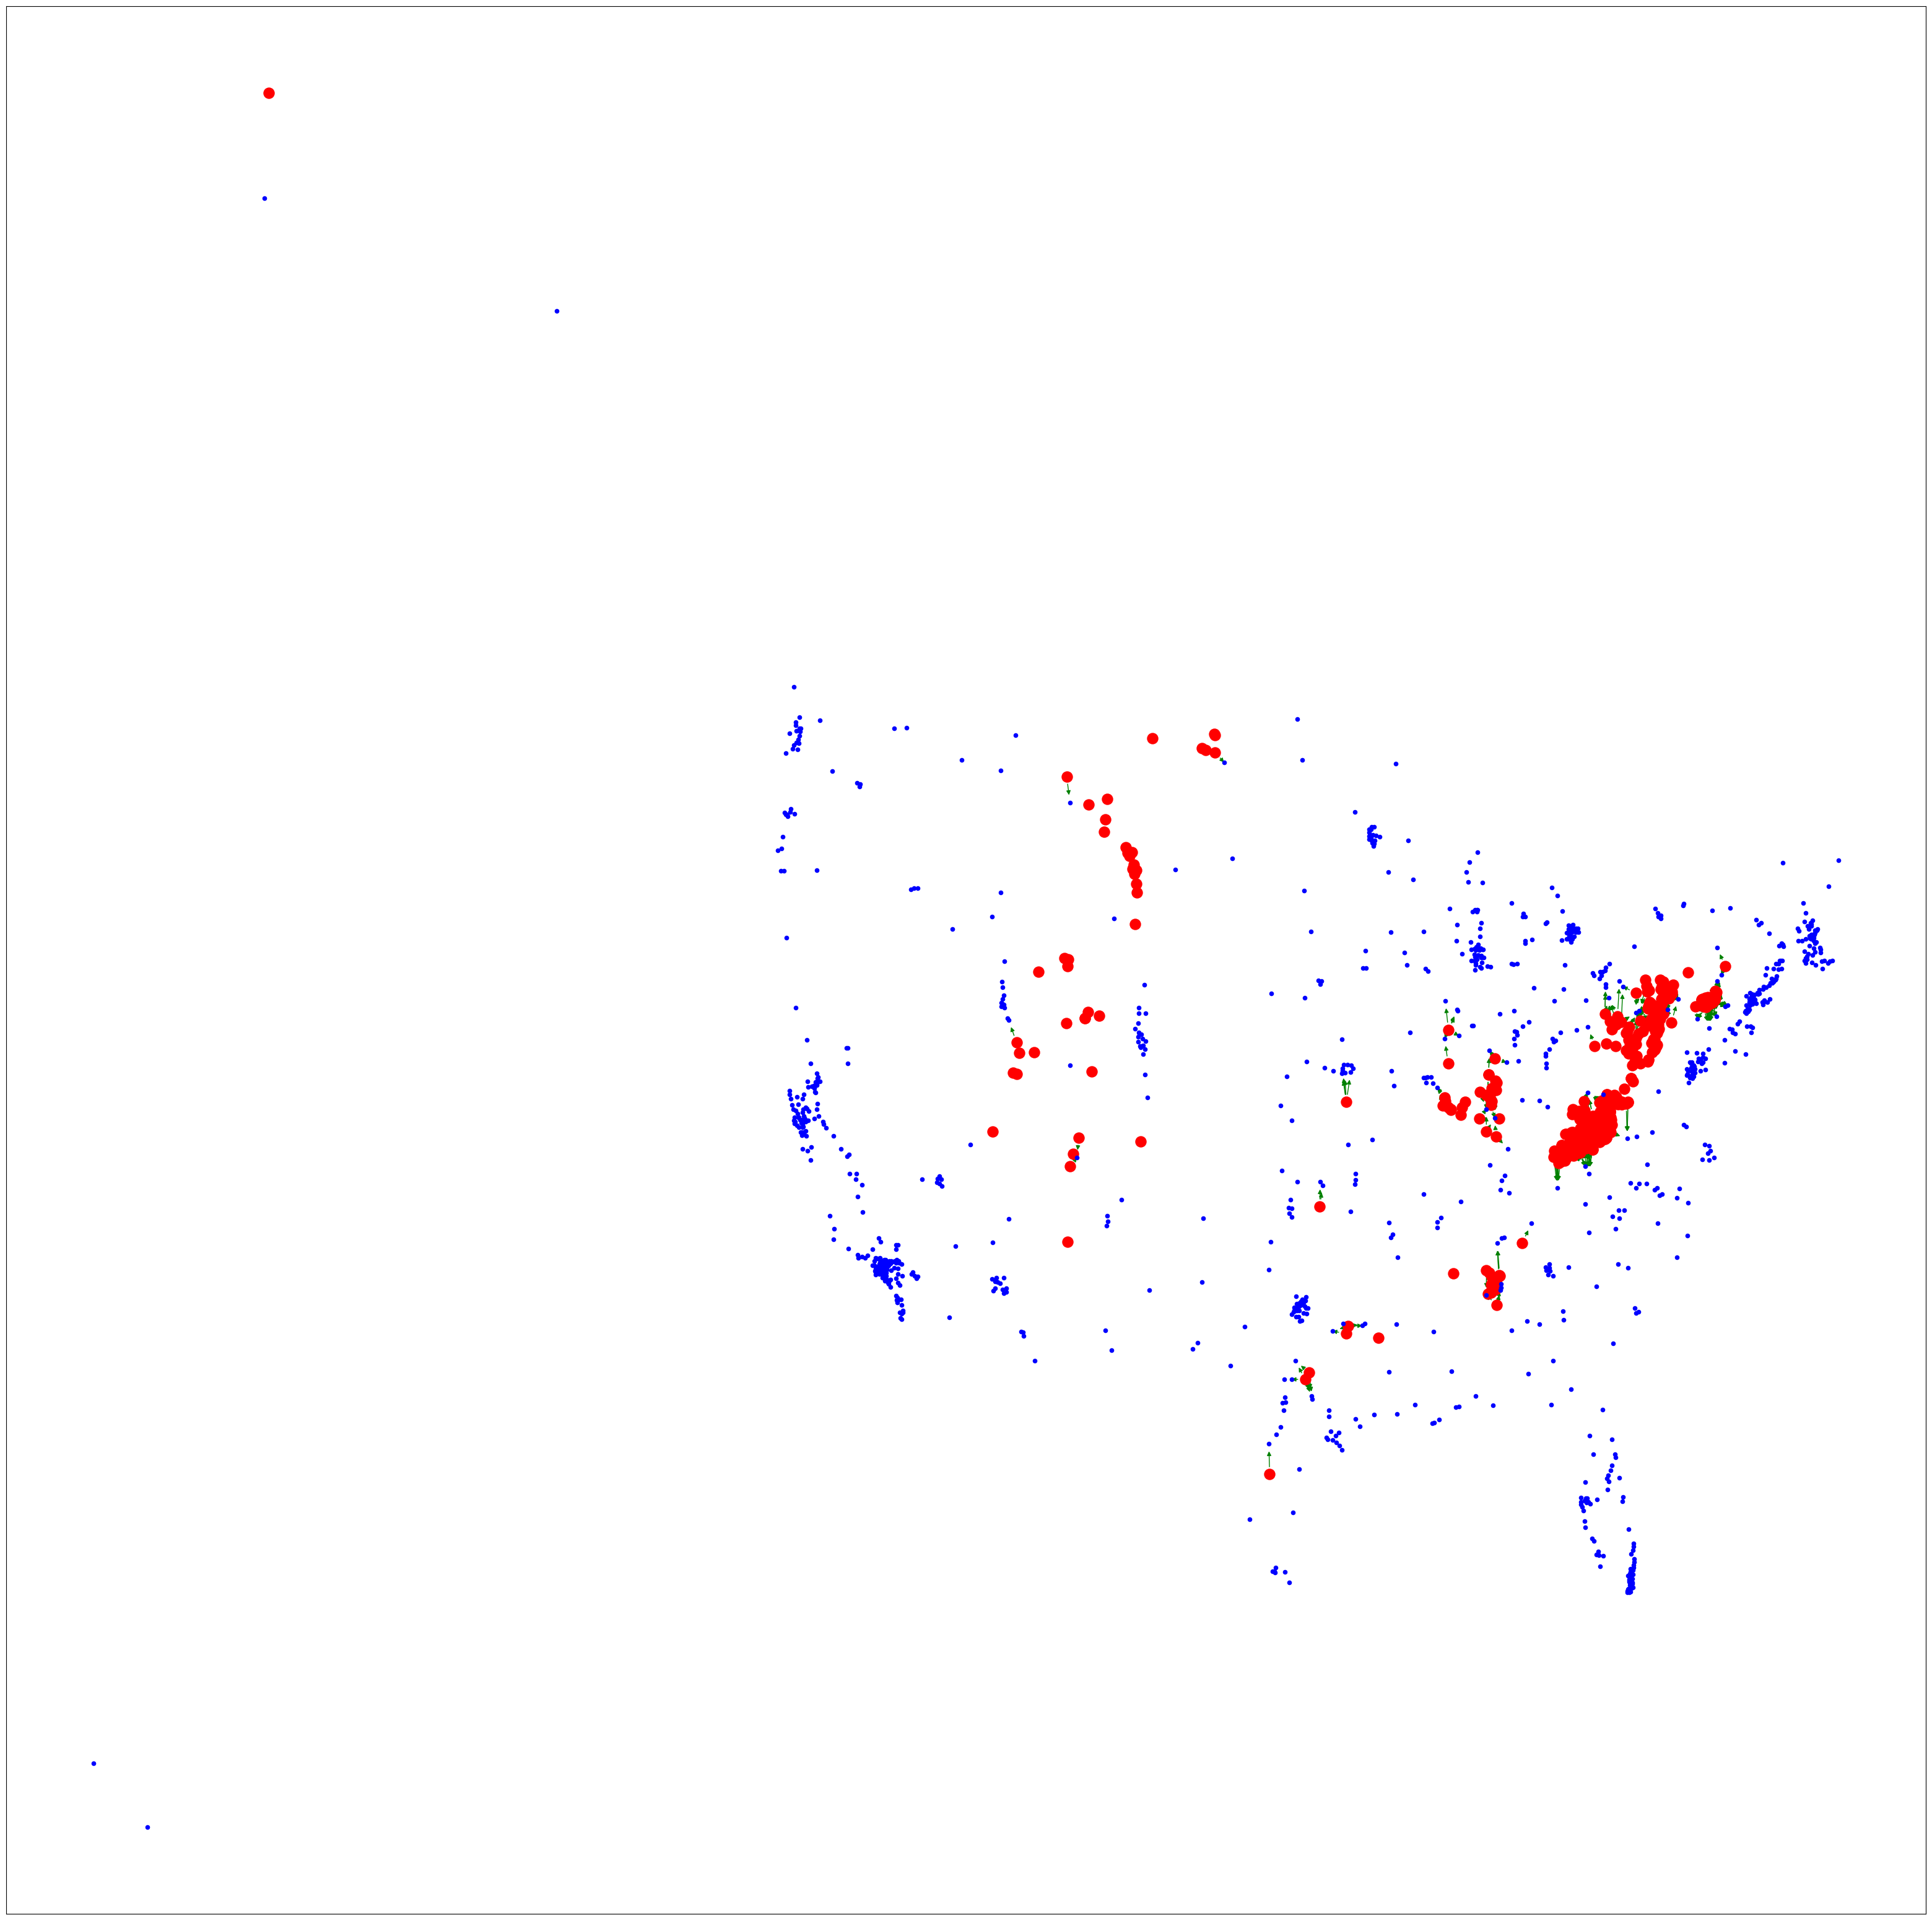

In [10]:


#setting up our figure(graphing canvas) size and creating subplots of size (1, 1)
pyp.rcParams["figure.figsize"] = (40, 40)
fig, ax = pyp.subplots(1, 1) 

edge_list = []
edge_capacities = {}


#iterating over both the coal and city node lists and checking if their weight is greater than 0 in the distance matrix
#if so, then we add it to the edge list 

#we also set the edge capacity - the amount of something that can flow on an edge as the inverse of the distance
for i in range(len(coal_nodes) - 1):
  for j in range(len(city_nodes) - 1):

   if(square_mat[i, j] > 0):
    edge_list.append((coal_nodes[i], city_nodes[j]))
    edge_capacities[edge_list[-1]] = 1 / square_mat[i, j]

print(len(edge_list))
dist_graph = nx.DiGraph()

#add and draw coal nodes, city nodes, and edges where necessary

dist_graph.add_nodes_from(coal_node_coord)
dist_graph.add_nodes_from(city_node_coord)
dist_graph.add_edges_from(edge_list)

nx.draw_networkx_nodes(dist_graph, ax=ax, pos=coal_node_coord, nodelist=coal_nodes, node_color="red", node_size=150)
nx.draw_networkx_nodes(dist_graph, ax=ax, pos=city_node_coord, nodelist=city_nodes, node_color="blue", node_size=20)
nx.draw_networkx_edges(dist_graph, edgelist=edge_list, pos=coal_city_node_coords, edge_color='green', width=1)

pyp.show()


Using MaxFlow

In [11]:

nx.set_edge_attributes(dist_graph, edge_capacities, "capacity")

u = coal_nodes[0]
v = city_nodes[2]

flow_val, flow_dict = nx.maximum_flow(dist_graph, u, v)



0


Representing MaxFlow as a QUBO

TypeError: cannot unpack non-iterable function object